Importing needed Libraries

In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

File Extraction

In [2]:
zip_file_path = r'C:\Users\laksh\Downloads\individual+household+electric+power+consumption.zip'
extract_path = r'C:\Users\laksh\Downloads\household_power_consumption'

#extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

#loading the dataset
csv_file_path = extract_path + r'\household_power_consumption.txt'  # Update based on actual file
data = pd.read_csv(csv_file_path, sep=';', low_memory=False)

#displaying dataset structure
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666

Data Preprocessing

In [3]:
#handling of missing values
data.replace('?', pd.NA, inplace=True)

#converting numeric columns to appropriate types
numeric_columns = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2'
]

for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#checking for missing values
print(data.isnull().sum())

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


Date and Time Parsing

In [4]:
#ensuring 'Time' is a string before concatenation with 'Date'
data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str), errors='coerce', dayfirst=True)

#extracting date and time component
data['Date'] = data['Datetime'].dt.date
data['Time'] = data['Datetime'].dt.time
data['Year'] = data['Datetime'].dt.year
data['Month'] = data['Datetime'].dt.month
data['Day'] = data['Datetime'].dt.day
data['Hour'] = data['Datetime'].dt.hour
data['Minute'] = data['Datetime'].dt.minute
data['Second'] = data['Datetime'].dt.second

#checking the updated dataframe
print(data.head())

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  2006-12-16  17:24:00                4.216                  0.418   234.84   
1  2006-12-16  17:25:00                5.360                  0.436   233.63   
2  2006-12-16  17:26:00                5.374                  0.498   233.29   
3  2006-12-16  17:27:00                5.388                  0.502   233.74   
4  2006-12-16  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0              18.4             0.0             1.0            17.0   
1              23.0             0.0             1.0            16.0   
2              23.0             0.0             2.0            17.0   
3              23.0             0.0             1.0            17.0   
4              15.8             0.0             1.0            17.0   

             Datetime  Year  Month  Day  Hour  Minute  Second  
0 2006-12-16 17:24:00  2006 

Handling missing data

In [5]:
#droping rows with missing Datetime
data.dropna(subset=['Datetime'], inplace=True)

#selecting only numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns

#filling missing numeric values with column mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

#confirming no missing values remain
print(data.isnull().sum())

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
Year                     0
Month                    0
Day                      0
Hour                     0
Minute                   0
Second                   0
dtype: int64


Feature Engineering

In [6]:
#adding new columns for date, hour, and day of the week
data['Date'] = data['Datetime'].dt.date
data['Hour'] = data['Datetime'].dt.hour
data['DayOfWeek'] = data['Datetime'].dt.day_name()

#calculating daily averages for energy consumption
daily_avg = data.groupby('Date').agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean'
}).reset_index()
daily_avg.rename(columns=lambda x: f'Daily_{x}' if x != 'Date' else x, inplace=True)

#adding rolling averages for energy consumption (e.g., 1-day and 7-day rolling averages)
data['Rolling_1Day'] = data['Global_active_power'].rolling(window=24).mean()
data['Rolling_7Day'] = data['Global_active_power'].rolling(window=24 * 7).mean()

#identifying peak usage times by finding the hour with the maximum average usage
hourly_avg = data.groupby('Hour').agg({'Global_active_power': 'mean'}).reset_index()
peak_hour = hourly_avg.loc[hourly_avg['Global_active_power'].idxmax(), 'Hour']
print(f"\nPeak usage hour based on average consumption: {peak_hour}:00")

#adding a flag for peak usage hours
data['IsPeakHour'] = data['Hour'].apply(lambda x: 1 if x == peak_hour else 0)

#summarizing energy usage by day of the week
weekly_avg = data.groupby('DayOfWeek').agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean'
}).reset_index()

#adding total energy consumed/day
data['DailyTotalEnergy'] = data.groupby('Date')['Global_active_power'].transform('sum')

scaler = MinMaxScaler()
data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']] = scaler.fit_transform(
    data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']]
)

#displaying the first few rows of the updated dataset
print("\nFeature-Engineered Dataset Preview:")
print(data.head())

#saving the feature-engineered dataset for later use
data.to_csv('feature_engineered_data.csv', index=False)


Peak usage hour based on average consumption: 20:00

Feature-Engineered Dataset Preview:
         Date      Time  Global_active_power  Global_reactive_power   Voltage  \
0  2006-12-16  17:24:00             0.374796               0.300719  0.376090   
1  2006-12-16  17:25:00             0.478363               0.313669  0.336995   
2  2006-12-16  17:26:00             0.479631               0.358273  0.326010   
3  2006-12-16  17:27:00             0.480898               0.361151  0.340549   
4  2006-12-16  17:28:00             0.325005               0.379856  0.403231   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0          0.377593             0.0             1.0            17.0   
1          0.473029             0.0             1.0            16.0   
2          0.473029             0.0             2.0            17.0   
3          0.473029             0.0             1.0            17.0   
4          0.323651             0.0             1.0            17.0 

Exploratory Data Analysis (EDA)

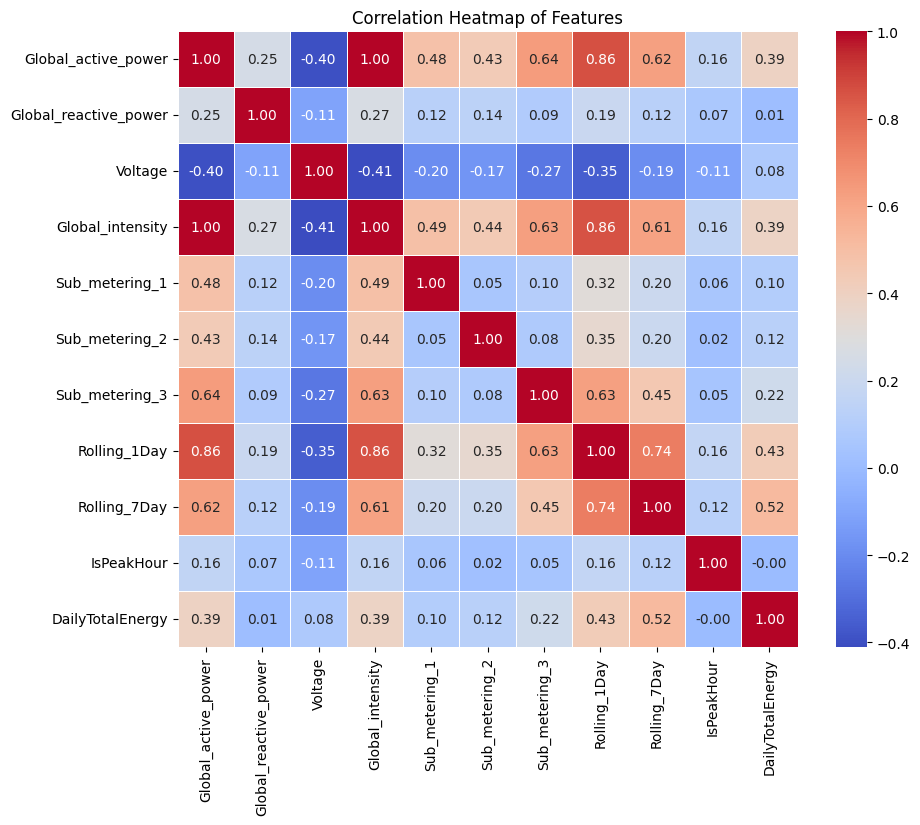

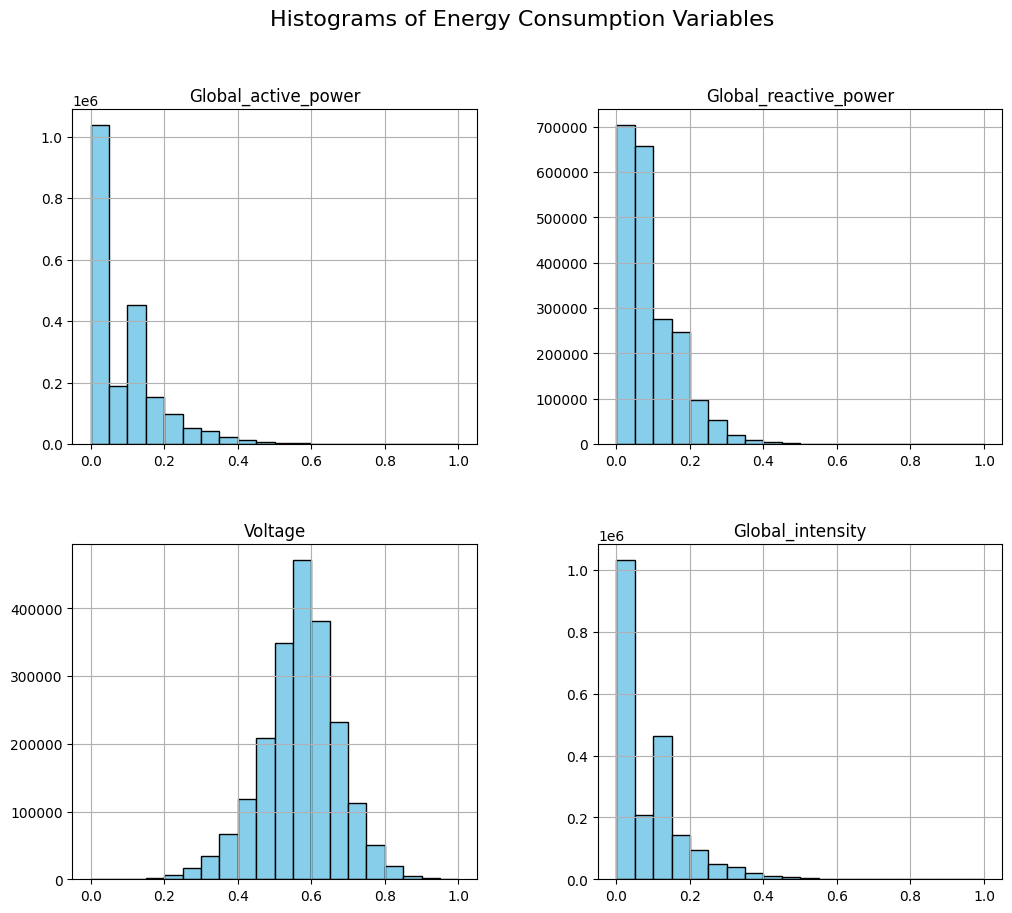

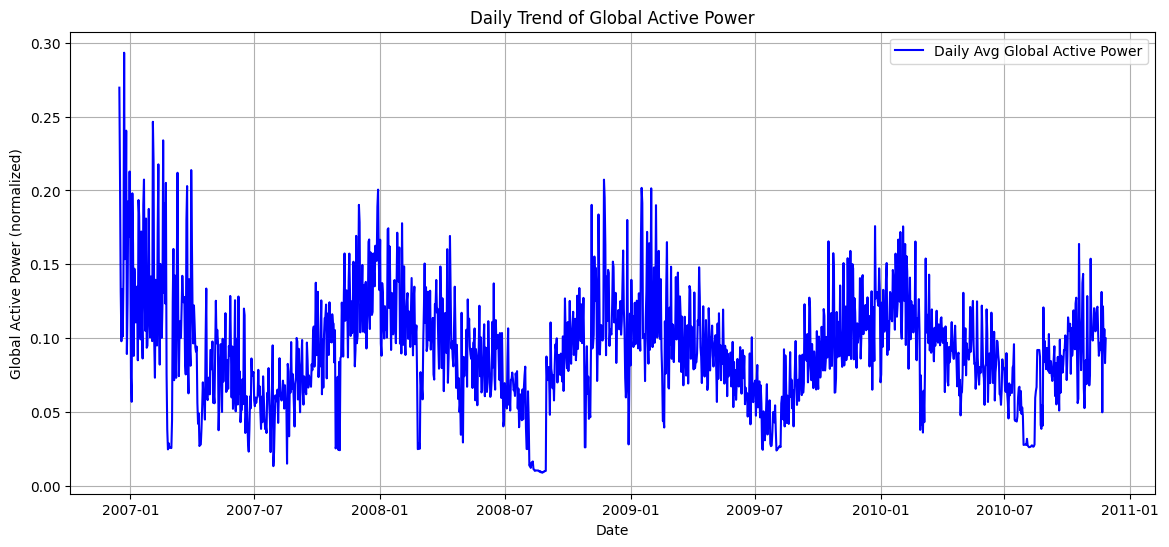

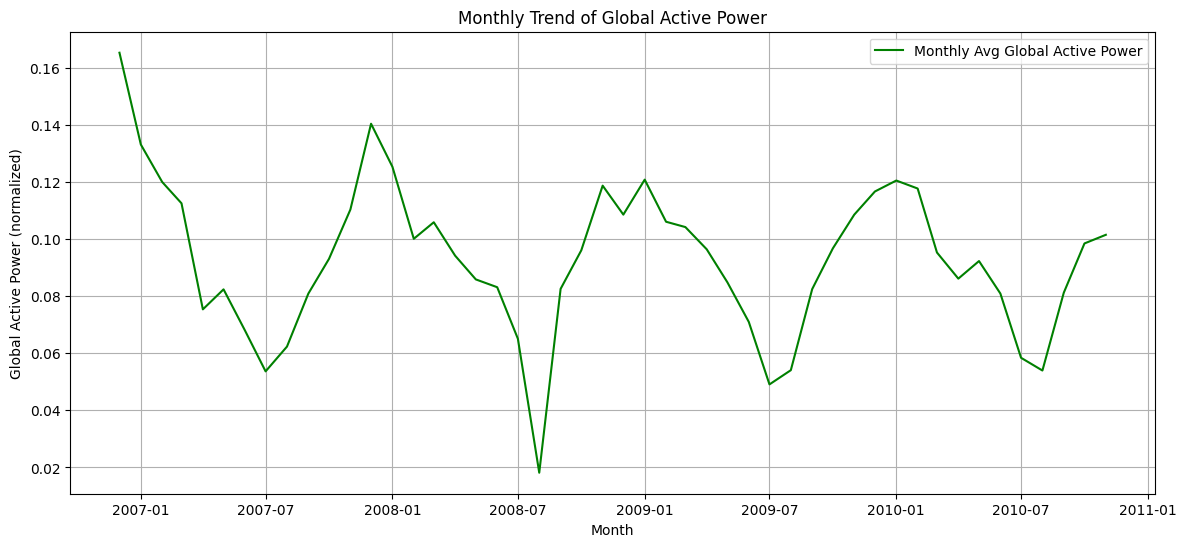

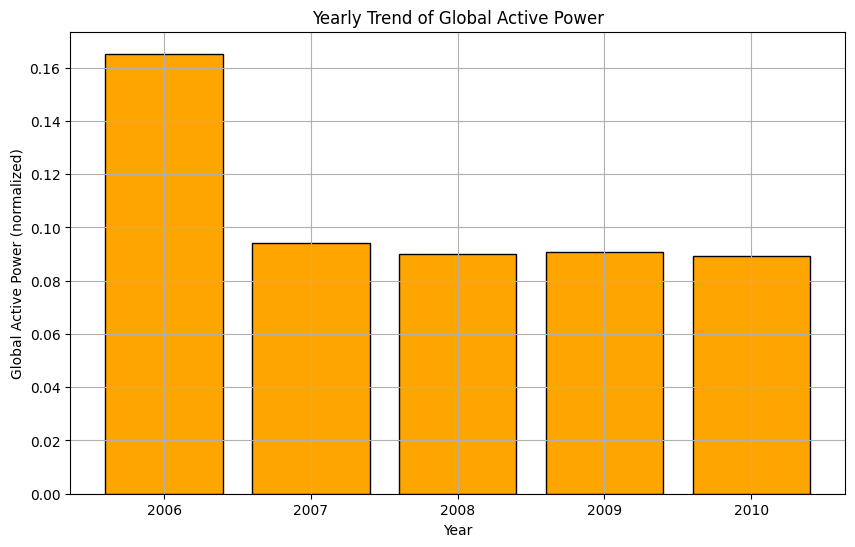

In [7]:
#ensuring that 'datetime' is in the correct datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce')

#filtering out only numeric columns(float64 and int64)
numeric_data = data.select_dtypes(include=['float64', 'int64'])

#1.correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()

#2.distribution analysis(histograms)
energy_vars = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
data[energy_vars].hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Energy Consumption Variables", fontsize=16)
plt.show()

#3.time series trends

#daily trend
data_daily = data.set_index('Datetime').resample('D').mean(numeric_only=True)
plt.figure(figsize=(14, 6))
plt.plot(data_daily.index, data_daily['Global_active_power'], label='Daily Avg Global Active Power', color='blue')
plt.title("Daily Trend of Global Active Power")
plt.xlabel("Date")
plt.ylabel("Global Active Power (normalized)")
plt.legend()
plt.grid(True)
plt.show()

#monthly trend
data['MonthYear'] = data['Datetime'].dt.to_period('M')
monthly_avg = data.groupby('MonthYear').mean(numeric_only=True)
plt.figure(figsize=(14, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg['Global_active_power'], label='Monthly Avg Global Active Power', color='green')
plt.title("Monthly Trend of Global Active Power")
plt.xlabel("Month")
plt.ylabel("Global Active Power (normalized)")
plt.legend()
plt.grid(True)
plt.show()

#yearly trend
data['Year'] = data['Datetime'].dt.year
yearly_avg = data.groupby('Year').mean(numeric_only=True)
plt.figure(figsize=(10, 6))
plt.bar(yearly_avg.index, yearly_avg['Global_active_power'], color='orange', edgecolor='black')
plt.title("Yearly Trend of Global Active Power")
plt.xlabel("Year")
plt.ylabel("Global Active Power (normalized)")
plt.grid(True)
plt.show()

Modeling

In [8]:
#->Linear Regression
#replacing 'Global_active_power' with the target variable
X = data[['Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]  # Example features
y = data['Global_active_power']

#train-test split(80%,20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#initializing and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

#prediction on the test set
y_pred = lr_model.predict(X_test)

#evaluating the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Baseline Model Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared (R²): {r2:.4f}")

Linear Regression Baseline Model Evaluation:
Root Mean Squared Error (RMSE): 0.0040
Mean Absolute Error (MAE): 0.0027
R-Squared (R²): 0.9982


Random Forest Regressor

In [9]:
#initializing the random forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=20)

#training the model
rf_model.fit(X_train, y_train)

#predictions
y_pred_rf = rf_model.predict(X_test)

#evaluating the random forest model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Model Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R-Squared (R²): {r2_rf:.4f}")


Random Forest Model Evaluation:
Root Mean Squared Error (RMSE): 0.0033
Mean Absolute Error (MAE): 0.0020
R-Squared (R²): 0.9988


Feature Importance


Feature Importances:
            Feature  Importance
1  Global_intensity    0.998850
0           Voltage    0.000565
2    Sub_metering_1    0.000261
4    Sub_metering_3    0.000180
3    Sub_metering_2    0.000144


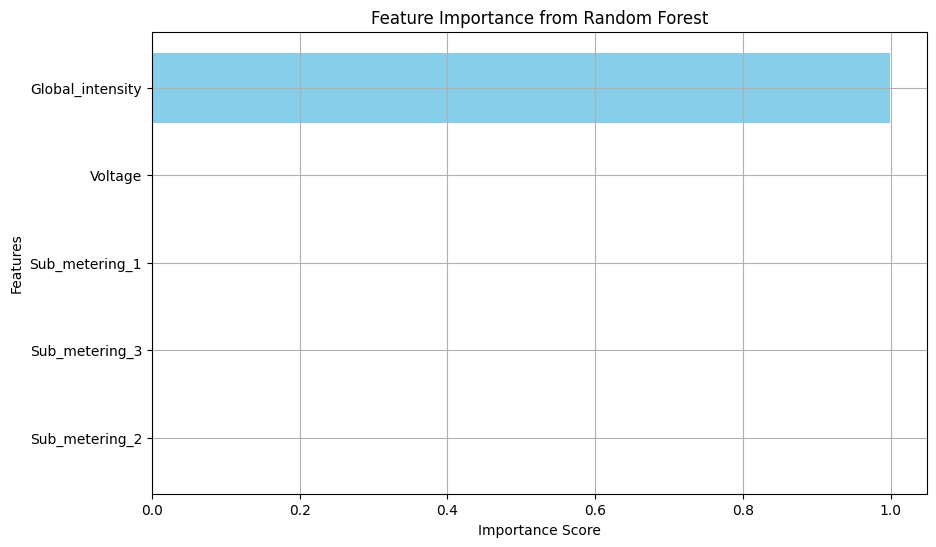

In [10]:
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

#plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

Summary and Insights

In [15]:
performance_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE": [rmse, rmse_rf],
    "MAE": [mae, mae_rf],
    "R²": [r2, r2_rf]
})

print("\nModel Performance Comparison:")
print(performance_comparison)


Model Performance Comparison:
               Model      RMSE       MAE        R²
0  Linear Regression  0.004038  0.002654  0.998198
1      Random Forest  0.003267  0.001988  0.998821


Time-series visualization of actual vs predicted values

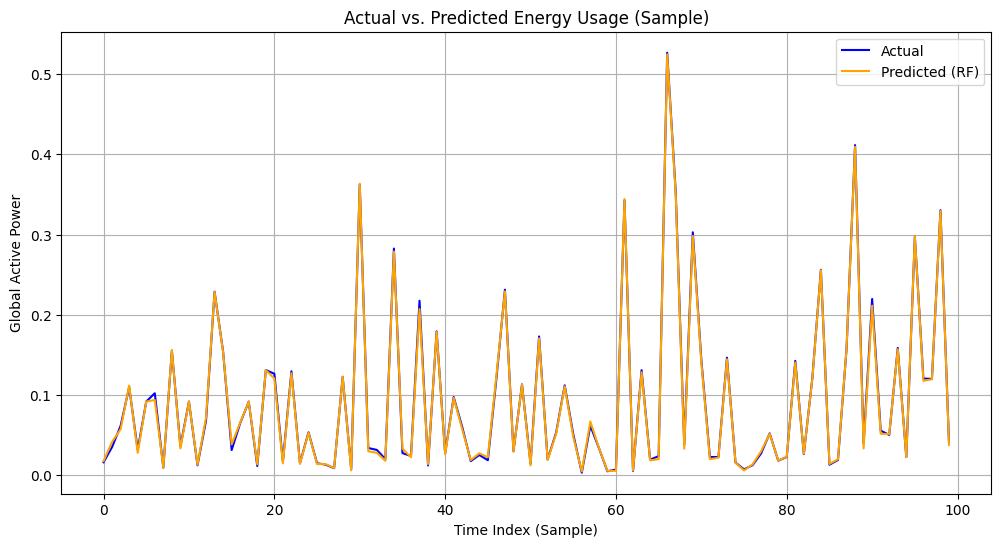

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue')
plt.plot(y_pred_rf[:100], label='Predicted (RF)', color='orange')
plt.title("Actual vs. Predicted Energy Usage (Sample)")
plt.xlabel("Time Index (Sample)")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.show()